<center style="font-size: 16px; font-weight: normal">
  `21 Microservices Architecture Patterns Study</center>

<center><h1>Chapter 3. Coupling and Abstractions</h1></center>

<center>
  Joseph Kim &lt;cloudeyes@gmail.com&gt;<br/>
  Jab 6. 2021<br/>
</center>

<center>
  <img src="https://images-na.ssl-images-amazon.com/images/I/51-q9CWNBHL._SX379_BO1,204,203,200_.jpg" style="width: 200px">
</center>

<center>
  <a href="https://github.com/cloudeyes/2021-msa-study/blob/main/03-coupling-and-abstractions/03-coupling-and-abstractions.ipynb">Download Jupyter Notebook</a>
</center>


# 03. Coupling and Abstractions

## Introduction

TDD 문제 풀이 사이트  

- https://kata-log.rocks/tdd
- https://www.programmingwithwolfgang.com/tdd-kata/


### Motivation

- what makes a good abstraction?
- What do we want from abstractions?
- And how do they relate to testing?

#### Global coupling is harmful

- Locally, coupling is a good thing: it’s a sign that our code is working together
  > "high cohesion" between the coupled elements.
- But, "globally" it harms maintainability
  - increasing the risk and the cost of changing our code
  - until we are no longer able to effectively change our systems.

#### Abstracting details fixes the coupling

**Lots of Coupling**

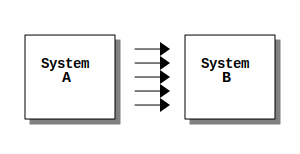

In [1]:
%%ditaa 
+--------+      +--------+
|        | ---> |        |
| System | ---> | System |
|   A    | ---> |   B    |
|        | ---> |        |
|        | ---> |        |
+--------+      +--------+

**Less Coupling**

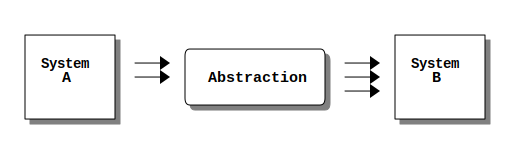

In [2]:
%%ditaa
+--------+                           +--------+
|        |      /-------------\      |        |
| System | ---> |             | ---> | System |
|   A    | ---> | Abstraction | ---> |   B    |
|        |      |             | ---> |        |
|        |      \-------------/      |        |
+--------+                           +--------+

## Abstracting state Aids Testability

### Example: synchronizing two directories

-  If a file "exists" in the source
  - **Rule 1:** then if it's not in the destination, copy the file over.
  - else it's in the destination but with a different name, 
    - **Rule 2:** rename the destination file to match.
- **Rule 3:** If a file exists in the destination but not in the source, remove it.

"Existence" of files should be checked by "hash value".

#### 1. "Hashing" a file to check identity

Generate a SHA-1 hash from a file to compare files.

In [3]:
BLOCKSIZE = 65536
from pathlib import Path
import hashlib

def hash_file(path: Path) -> str:
    hasher = hashlib.sha1()
    with path.open("rb") as file:
        buf = file.read(BLOCKSIZE)
        while buf:
            hasher.update(buf)
            buf = file.read(BLOCKSIZE)
    return hasher.hexdigest()

In [4]:
@test
def test_hash_file():
    import os
    os.makedirs('./build', exist_ok=True)
    inpath  = Path('03-coupling-and-abstractions.ipynb')
    outpath = Path('./build') / inpath
    
    with open(inpath) as fin:
        with open(outpath, 'w+') as fout:
            fout.write(fin.read())
            
    print(h1 := hash_file(inpath))
    assert h1 == hash_file(outpath) 

c80e5f5cc2afaa7fa9e149f1f40b6165237c28ba
✅ test_hash_file


#### 2. Basic sync algorithm

Implement the business logic in this way:
- Start with a solution to the smallest part of the problem.
- And then iteratively make the solution richer and better designed.

##### Make a sample test files

In [5]:
!rm -rf tests/ex1 \
&& mkdir -p tests/ex1/{source,target} \
&& echo "I am a very useful file" > tests/ex1/source/my-file \
&& echo "I am a special file" > tests/ex1/source/special-file \
&& echo "You are a very useful file" > tests/ex1/target/your-file \
&& echo "I am a very useful file" > tests/ex1/target/renamed-my-file \
&& tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── renamed-my-file
    └── your-file

2 directories, 4 files


##### Create a test first that fails

In [6]:
def sync(source: str, dest: str) -> None:
    raise NotImplementedError

@test
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    sync('tests/ex1/source', 'tests/ex1/target')

Traceback (most recent call last):
  File "<ipython-input-6-78acc283b242>", line 2, in sync
    raise NotImplementedError
NotImplementedError


##### Play with Jupyter notebook to build some scaffolds

In [7]:
for folder, dirs, files in os.walk('tests/ex1'): print(folder, _, files)

tests/ex1 <IPython.core.display.SVG object> []
tests/ex1/source <IPython.core.display.SVG object> ['special-file', 'my-file']
tests/ex1/target <IPython.core.display.SVG object> ['renamed-my-file', 'your-file']


In [8]:
src_path = Path('./tests/ex1/source')
dst_path = Path('./tests/ex1/target')

def hash_files(path: Path(folder)) -> dict[str, str]:
    hashes = dict[str, str]()

    for folder, _, files in os.walk(path):
        for fname in files:
            hashes[hash_file(Path(folder) / fname)] = fname

    return hashes

src_hashes, dst_hashes = hash_files(src_path), hash_files(dst_path)
src_hashes, dst_hashes

({'82133f2e33bcea9bbadf74c5e2438e5e0db07a33': 'special-file',
  '4a17979d33f38b7c36e38a6b02013b2f2ef01fbb': 'my-file'},
 {'4a17979d33f38b7c36e38a6b02013b2f2ef01fbb': 'renamed-my-file',
  '197f216e99637a19a46c44ea849b4bb493e92275': 'your-file'})

In [9]:
src_keys, dst_keys = src_hashes.keys(), dst_hashes.keys()
src_keys, dst_keys

(dict_keys(['82133f2e33bcea9bbadf74c5e2438e5e0db07a33', '4a17979d33f38b7c36e38a6b02013b2f2ef01fbb']),
 dict_keys(['4a17979d33f38b7c36e38a6b02013b2f2ef01fbb', '197f216e99637a19a46c44ea849b4bb493e92275']))

In [10]:
src_only = src_keys - dst_keys; src_only

{'82133f2e33bcea9bbadf74c5e2438e5e0db07a33'}

In [11]:
dst_only = dst_keys - src_keys; dst_only

{'197f216e99637a19a46c44ea849b4bb493e92275'}

In [12]:
in_both = src_keys & dst_keys; in_both

{'4a17979d33f38b7c36e38a6b02013b2f2ef01fbb'}

##### Implement business rules

**Rule 1**: Copy a file from to destination if the file exists **only** in the source.

In [13]:
!tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── renamed-my-file
    └── your-file

2 directories, 4 files


In [14]:
import shutil

for key in src_only:
    file_name = src_hashes[key]
    src_file_path = src_path / file_name
    dst_file_path = dst_path / file_name
    shutil.copy(src_file_path, dst_file_path)

`special-file` should be copied to `target` folder.

In [15]:
!tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── renamed-my-file
    ├── special-file
    └── your-file

2 directories, 5 files


**Rule 3**: Remove a file from destination if it's not in the source, 

In [16]:
for key in dst_only:
    file_name = dst_hashes[key]
    dst_file_path = dst_path / file_name
    try:
        os.remove(dst_file_path)
    except FileNotFoundError:
        pass

`your-file` should be removed from `target` folder.

In [17]:
!tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── renamed-my-file
    └── special-file

2 directories, 4 files


**Rule 2**: *Rename the destination's file name to match* if the file "exists" both in the source and destination but with different names. 

In [18]:
for key in in_both:
    src_name, dst_name = src_hashes[key], dst_hashes[key]
    dst_path_from = dst_path / dst_name
    dst_path_to   = dst_path / src_name
    try:
        os.rename(dst_path_from, dst_path_to)
    except FileNotFoundError:
        pass

In [19]:
!tree tests/ex1

tests/ex1
├── source
│   ├── my-file
│   └── special-file
└── target
    ├── my-file
    └── special-file

2 directories, 4 files


Sync Completed! :D

##### Build the real service function from the tryouts

In [20]:
import hashlib
import os
import shutil
from pathlib import Path

def sync(source: str, dest: str) -> None:
    src_path = Path(source)
    dst_path = Path(dest)

    src_hashes, dst_hashes = hash_files(src_path), hash_files(dst_path)
    src_keys, dst_keys = src_hashes.keys(), dst_hashes.keys()
    
    src_only = src_keys - dst_keys
    dst_only = dst_keys - src_keys
    in_both  = src_keys & dst_keys
    
    for key in src_only:
        file_name = src_hashes[key]
        src_file_path = src_path / file_name
        dst_file_path = dst_path / file_name
        shutil.copy(src_file_path, dst_file_path)
        
    for key in dst_only:
        file_name = dst_hashes[key]
        dst_file_path = dst_path / file_name
        try:
            os.remove(dst_file_path)
        except FileNotFoundError:
            pass

    for key in in_both:
        src_name, dst_name = src_hashes[key], dst_hashes[key]
        dst_path_from = dst_path / dst_name
        dst_path_to   = dst_path / src_name
        try:
            os.rename(dst_path_from, dst_path_to)
        except FileNotFoundError:
            pass

##### Create a general fixture function.

In [21]:
def make_test_files(base_dir, src_only=False, dst_only=False, renamed=False):
    base_path = Path(base_dir)
    src_path  = base_path / 'source'
    dst_path  = base_path / 'target'
    shutil.rmtree(base_dir, ignore_errors=True)
    os.makedirs(src_path, exist_ok=True)
    os.makedirs(dst_path, exist_ok=True)
    src_only and (src_path / 'special-file').write_text('I am a special file')
    dst_only and (dst_path / 'your-file').write_text('You are a very useful file')
    renamed and (src_path / 'my-file').write_text('I am a very useful file')
    renamed and (dst_path / 'renamed-my-file').write_text('I am a very useful file')
    
make_test_files('tests/ex1', dst_only=True)
!tree tests

tests
└── ex1
    ├── source
    └── target
        └── your-file

3 directories, 1 file


##### Run tests with the real service implementation.

In [22]:
@test
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    try:
        make_test_files('tests/ex1', src_only=True)
        sync('tests/ex1/source', 'tests/ex1/target')
    finally: # clenaup test files
        shutil.rmtree('tests/ex1', ignore_errors=True)

!ls tests

✅ test_when_a_file_exists_in_the_source_but_not_the_destination


In [23]:
@test
def test_when_a_file_has_been_renamed_in_the_source(renamed=True):
    try:
        make_test_files('tests/ex1', src_only=True)
        sync('tests/ex1/source', 'tests/ex1/target')
    finally: # clenaup test files
        shutil.rmtree('tests/ex1', ignore_errors=True)

✅ test_when_a_file_has_been_renamed_in_the_source


#### Lessons learned:

Our domain logic:
- “figure out the difference between two directories,” 

has problems such as:
- it's *tightly coupled to the I/O code*. 
  - We can’t run our difference algorithm without calling the `pathlib`, `shutil`, and `hashlib`.
- we *haven’t written enough tests** even with our current requirements
- which makes the code isn’t very extensible. Let's imagine:
  - add `--dry-run` flag that just simulate the sync
  - or to sync to a remote server, or to cloud storage?

## Choosing the Right Abstractions(s)

Rewrite our code to make it more testable.
 
Find **simplifying abstractions** for *three distinct responsibilities* that the code has:

1. **Determine hashes** for a series of paths from both the source and the destination.
1. **Decide differences** whether each file is new, renamed, or redundant.
1. **Do corresponding actions**: copy, move, or delete files to match the source.

#### Simplified inputs and outputs in our tests (`test_sync.py`)

In [24]:
from unittest.mock import MagicMock
determine_actions = MagicMock()

@test
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    src_hashes = {'hash1': 'fn1'}
    dst_hashes = {}
    expected_actions = [('copy', Path('/src/fn1'), Path('/dst/fn1'))]
    actions = list(determine_actions(src_hashes, dst_hashes, '/src', '/dst'))
    assert expected_actions == actions
    
@test
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    src_hashes = {'hash1': 'fn1'}
    dst_hashes = {'hash1': 'fn2'}
    expected_actions = [('move', Path('/dst/fn2'), Path('/dst/fn1'))]
    actions = list(determine_actions(src_hashes, dst_hashes, '/src', '/dst'))
    assert expected_actions == actions

Traceback (most recent call last):
  File "<ipython-input-24-c1ba3c06668e>", line 10, in test_when_a_file_exists_in_the_source_but_not_the_destination
    assert expected_actions == actions
AssertionError
Traceback (most recent call last):
  File "<ipython-input-24-c1ba3c06668e>", line 18, in test_when_a_file_exists_in_the_source_but_not_the_destination
    assert expected_actions == actions
AssertionError


## Implementing Our Chosen Abstractions

Our goal is to isolate our "core" logic from the filesystem.
- create “core” of code that has no dependencies on external state
- see how it responds when we give it input from the outside world.

See also:
- [Functional Core, Imperative Shell by Gary Bernhardt](https://www.destroyallsoftware.com/screencasts/catalog/functional-core-imperative-shell)

#### Split our code into three (`sync.py`)

In [25]:
from pathlib import Path

def sync(source, dest):
    # step 1: imperative shell - gather inputs
    source_hashes = read_paths_and_hashes(source)
    dest_hashes = read_paths_and_hashes(dest)

    # step 2: call functional core
    actions = determine_actions(source_hashes, dest_hashes, source, dest)

    # step 3: imperative shell - apply outputs
    for action, *paths in actions:
        if action == 'copy':
            shutil.copyfile(*paths)
        if action == 'move':
            shutil.move(*paths)
        if action == 'delete':
            os.remove(paths[0])

#### A function that just does I/O (`sync.py`)

In [26]:
def read_paths_and_hashes(root):
    hashes = {}
    for folder, _, files in os.walk(root):
        for fn in files:
            hashes[hash_file(Path(folder) / fn)] = fn
    return hashes

#### A function that just does business logic (`sync.py`)

In [27]:
HashDict = dict[str, str]
def determine_actions(src_hashes: HashDict, dst_hashes: HashDict, 
                      src_folder: str, dst_folder: str):
    src_keys, dst_keys = src_hashes.keys(), dst_hashes.keys()
    src_path, dst_path = Path(src_folder), Path(dst_folder)
    
    src_only = src_keys - dst_keys
    dst_only = dst_keys - src_keys
    in_both  = src_keys & dst_keys
    
    for key in src_only:
        file_name = src_hashes[key]
        src_file_path = src_path / file_name
        dst_file_path = dst_path / file_name        
        yield 'copy', src_file_path, dst_file_path
        
    for key in dst_only:
        file_name = dst_hashes[key]
        dst_file_path = dst_path / file_name
        yield 'delete', dst_file_path

    for key in in_both:
        src_name, dst_name = src_hashes[key], dst_hashes[key]
        dst_path_from = dst_path / dst_name
        dst_path_to   = dst_path / src_name
        yield 'move', dst_path_from, dst_path_to

In [28]:
@test
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    src_hashes = {'hash1': 'fn1'}
    dst_hashes = {}
    expected_actions = [('copy', Path('/src/fn1'), Path('/dst/fn1'))]
    actions = list(determine_actions(src_hashes, dst_hashes, '/src', '/dst'))
    assert expected_actions == actions
    
@test
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    src_hashes = {'hash1': 'fn1'}
    dst_hashes = {'hash1': 'fn2'}
    expected_actions = [('move', Path('/dst/fn2'), Path('/dst/fn1'))]
    actions = list(determine_actions(src_hashes, dst_hashes, '/src', '/dst'))
    assert expected_actions == actions

✅ test_when_a_file_exists_in_the_source_but_not_the_destination
✅ test_when_a_file_exists_in_the_source_but_not_the_destination


### Testing Edge to Edge with Fakes and Dependency Injection

Instead, we often write tests that invoke a whole system together but fake the I/O, sort of *edge to edge*:

#### Explicit dependencies (`sync.py`)

It now exposes two new dependencies, a `reader` and a `filesystem`.
- `reader`: produce our files hashes.
- `filesystem`: apply the changes we detect.

In [29]:
def sync_dirs(reader, filesystem, source: str, dest: str):

    # step 1: imperative shell - gather inputs
    source_hashes = reader(source)
    dest_hashes = reader(dest)

    # step 2: call functional core
    actions = determine_actions(source_hashes, dest_hashes, source, dest)

    # step 3: imperative shell - apply outputs
    for action, *paths in actions:
        if action == 'copy':
            filesystem.copy(paths[0], paths[1])
        if action == 'move':
            filesystem.move(paths[0], paths[1])
        if action == 'delete':
            filesystem.delete(paths[0])

#### Tests using DI

In [30]:
class FakeFileSystem(list): 
    """An example of spy object.
    
    Extend list to collection operations on fake filesystem.
    """
    
    def copy(self, src, dest):
        self.append(('copy', src, dest))

    def move(self, src, dest):
        self.append(('move', src, dest))

    def delete(self, dest):
        self.append(('delete', src, dest))

In [31]:
@test
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    source = {"sha1": "my-file" }
    dest = {}
    filesystem = FakeFileSystem()

    reader = {"/source": source, "/dest": dest}
    sync_dirs(reader.pop, filesystem, "/source", "/dest")

    assert filesystem == [("copy", Path("/source/my-file"), Path("/dest/my-file"))]

@test
def test_when_a_file_has_been_renamed_in_the_source():
    source = {"sha1": "renamed-file" }
    dest = {"sha1": "original-file" }
    filesystem = FakeFileSystem()

    reader = {"/source": source, "/dest": dest}
    sync_dirs(reader.pop, filesystem, "/source", "/dest")

    assert filesystem == [("move", Path("/dest/original-file"), Path("/dest/renamed-file"))]

✅ test_when_a_file_exists_in_the_source_but_not_the_destination
✅ test_when_a_file_has_been_renamed_in_the_source


#### Pros and Cons: 

- Pros: tests act on the exact same function that’s used by our production code
- Cons: we have to make our stateful components explicit and pass them around

[“Test-induced design damage” by David Heinemeier Hansson](https://dhh.dk/2014/test-induced-design-damage.html)

> But that's a far ways off from declaring that hard-to-unit-test code is always poorly designed, and always in need of repair. That you cannot have well-designed code that is hard to unit test.


### Why Not Just Patch It Out?

“Why don’t you just use mock.patch and save yourself the effort?"” 
The author thinks:
- Mocking frameworks, particularly monkeypatching, are a code smell.
- A Better way is:
  - to clearly identify the responsibilities in codebases, 
  - to separate those responsibilities into small, focused objects 
    - that are easy to replace with a test double.

Reasons why:

- Patching does nothing to improve the design. 
  > e.g) using `mock.patch` won’t let your code work with a `--dry-run` flag, nor will it help you run against an FTP server. For that, you’ll need to introduce abstractions.
- Mocks tend to be more coupled to the implementation details of the codebase. 
- Overuse of mocks leads to complicated test suites that fail to explain the code
- Designing for testability really means designing for extensibility.
  - Trade off *a little more complexity* for a cleaner design that admits novel use cases.

*See also*:

- [Test Double (explained by Martin Fowler)](https://martinfowler.com/bliki/TestDouble.html#:~:text=Test%20Double%20is%20a%20generic,used%20to%20fill%20parameter%20lists.)

> a generic term for any case where you replace a production object for testing purposes. There are various kinds of double that Gerard lists:
> 
> - **Dummy** objects are passed around but never actually used. Usually they are just used to fill parameter lists.
> - **Fake** objects actually have working implementations, but usually take some shortcut which makes them not suitable for production (an InMemoryTestDatabase is a good example).
> - **Stubs** provide canned answers to calls made during the test, usually not responding at all to anything outside what's programmed in for the test.
> - **Spies** are stubs that also record some information based on how they were called. One form of this might be an email service that records how many messages it was sent.
> - **Mocks** are pre-programmed with expectations which form a specification of the calls they are expected to receive. They can throw an exception if they receive a call they don't expect and are checked during verification to ensure they got all the calls they were expecting.

### Mocks versus Fakes

- **Mocks** are used to *verify how* something gets used.
  - have methods like `assert_called_once_with()`. (associated with London-school TDD)
- **Fakes** are *working implementations* of the thing they’re replacing.
 - designed for use only in tests: they wouldn’t work “in real life”.
   > our in-memory repository is a good example. But you can use them to make assertions about the end state of a system rather than the behaviors along the way, so they’re associated with classic-style TDD.
   
#### Mock examples:

- https://docs.python.org/3/library/unittest.mock.html
- [Python Mocking 101: Fake It Before You Make It](https://www.fugue.co/blog/2016-02-11-python-mocking-101)

In [32]:
from unittest import mock
from unittest.mock import call, MagicMock

@test
@mock.patch('__main__.read_paths_and_hashes', MagicMock(side_effect={
    "/source":  {"sha1": "my-file" },
    "/dest": {},
}.get))
@mock.patch('shutil.copyfile', MagicMock())
def test_when_a_file_exists_in_the_source_but_not_the_destination():
    sync("/source", "/dest")
    read_paths_and_hashes.assert_has_calls([mock.call('/source'), mock.call('/dest')])
    assert [call(Path('/source/my-file'), Path('/dest/my-file'))] \
        == shutil.copyfile.mock_calls

✅ test_when_a_file_exists_in_the_source_but_not_the_destination


*See also*:

- [“Mocks Aren’t Stubs” by Martin Folwer](https://martinfowler.com/articles/mocksArentStubs.html)
- [What are the London and Chicago schools of TDD? -  Software Engineering Stack Exchange](https://softwareengineering.stackexchange.com/questions/123627/what-are-the-london-and-chicago-schools-of-tdd)

## Wrap-Up

- Finding the right abstraction is tricky
- A few heuristics and questions to ask yourself:
  - Can I choose a familiar Python data structure to represent the state of the messy system and then try to imagine a single function that can return that state?
  - Where can I draw a line between my systems, where can I carve out a seam to stick that abstraction in?
  - What is a sensible way of dividing things into components with different responsibilities? What implicit concepts can I make explicit?
  - What are the dependencies, and what is the core business logic?